Import Libraries

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

Data Loading and Preprocessing

In [ ]:
# Load dataset
data = pd.read_csv('/content/HistoricalData.csv')
data['Date'] = pd.to_datetime(data['Date'])  # Convert Date column to datetime
data = data.sort_values('Date').set_index('Date')  # Sort by date and set as index

# Extract the target column for prediction
closing_price = data['Close/Last'].values.reshape(-1, 1)

# Drop any unnecessary columns
data = data.drop(columns=['Volume'])  # Dropping 'Volume' as it's not used

# Scale the closing price data for LSTM model input
scaler = MinMaxScaler()
closing_price_scaled = scaler.fit_transform(closing_price)
# Display basic information about the dataset
print("Data Overview:")
print(data.head(), "\n")
print("Data Summary:")
print(data.describe())
print("Data Types:")
print(data.dtypes)

Data Overview:
            Close/Last     Open    High     Low
Date                                           
2019-03-08     70.0190  70.0190  70.498  69.769
2019-03-11     69.8003  69.8003  70.032  69.722
2019-03-12     69.8550  69.8550  69.855  69.558
2019-03-13     69.5672  69.5672  69.855  69.401
2019-03-14     69.3360  69.3360  69.927  69.255 

Data Summary:
        Close/Last         Open         High          Low
count  1155.000000  1155.000000  1155.000000  1155.000000
mean     75.025124    75.010120    75.148041    74.926052
std       3.545796     3.537324     3.555338     3.530461
min      68.346000    68.399000    68.419000    68.346000
25%      72.942500    72.939000    73.033000    72.866000
50%      74.468000    74.467000    74.557000    74.375000
75%      76.292550    76.313750    76.436000    76.195000
max      83.037000    83.013000    83.096000    82.955000
Data Types:
Close/Last    float64
Open          float64
High          float64
Low           float64
dtype: obje

 exploratory data analysis

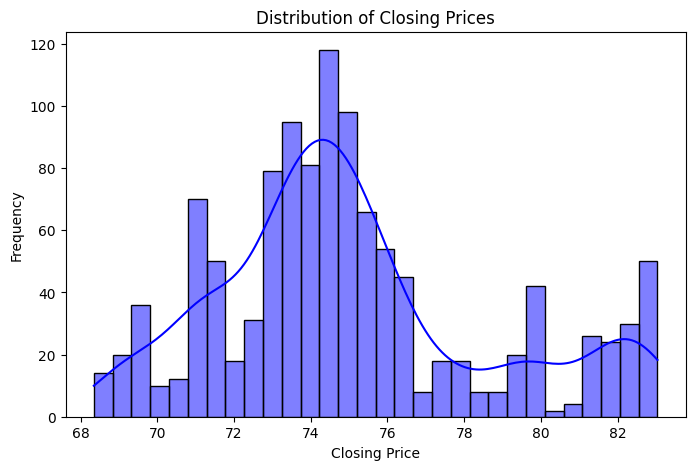

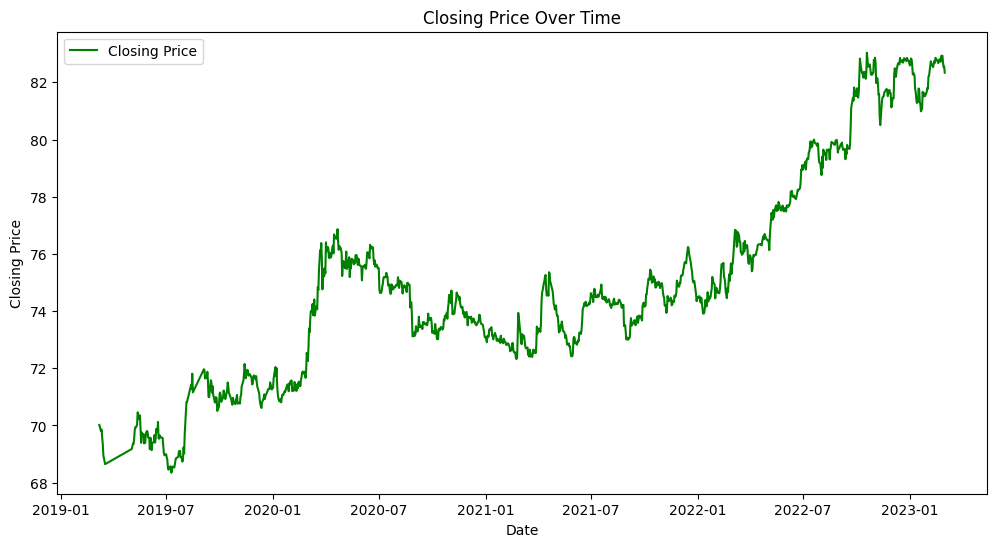

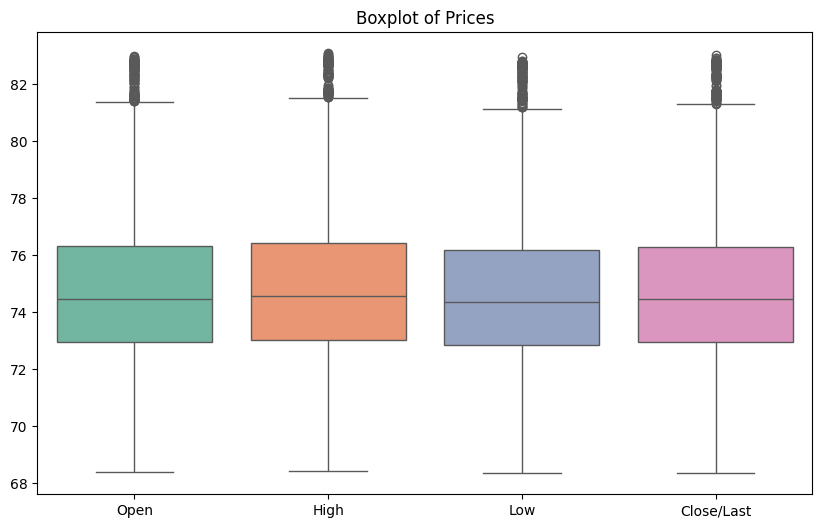

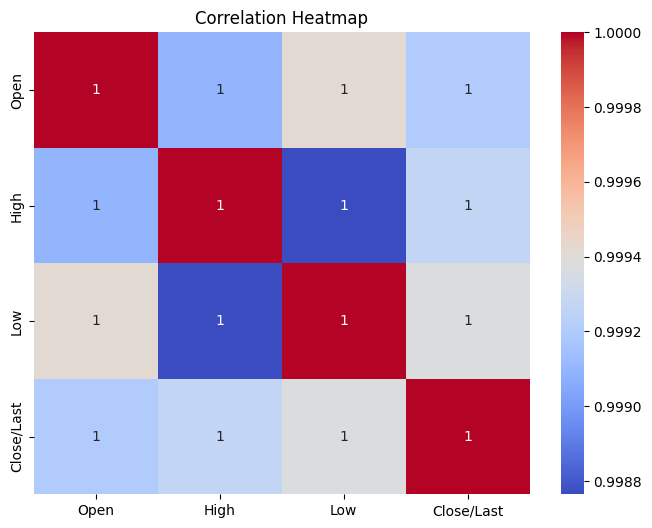

In [ ]:
# Distribution of Closing Prices
plt.figure(figsize=(8, 5))
sns.histplot(data['Close/Last'], kde=True, bins=30, color='blue')
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

# Adding spacing between the graphs
print('\n' * 2)

# Trend of Closing Prices Over Time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close/Last'], label='Closing Price', color='green')
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Adding spacing between the graphs
print('\n' * 2)

# Boxplot for Prices (Open, High, Low, Close)
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['Open', 'High', 'Low', 'Close/Last']], palette='Set2')
plt.title('Boxplot of Prices')
plt.show()

# Adding spacing between the graphs
print('\n' * 2)

# Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = data[['Open', 'High', 'Low', 'Close/Last']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Prepare Training and Test Data

In [ ]:
# Set parameters for sequence length and test size
sequence_length = 70
test_size = 150

# Function to create sequences for training/testing
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Prepare training data
X_train, y_train = create_sequences(closing_price_scaled[:-test_size], sequence_length)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Prepare test data
X_test, y_test = create_sequences(closing_price_scaled[-(test_size + sequence_length):], sequence_length)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = y_test.reshape(-1, 1)

Define and Compile the LSTM Model

In [ ]:
# Build LSTM model architecture
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(units=50),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 70, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Train the Model with Early Stopping


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0761
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.1837e-04
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.9668e-04
Epoch 13/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.4552e-04
Epoch 14/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.5627e-04
Epoch 15/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/

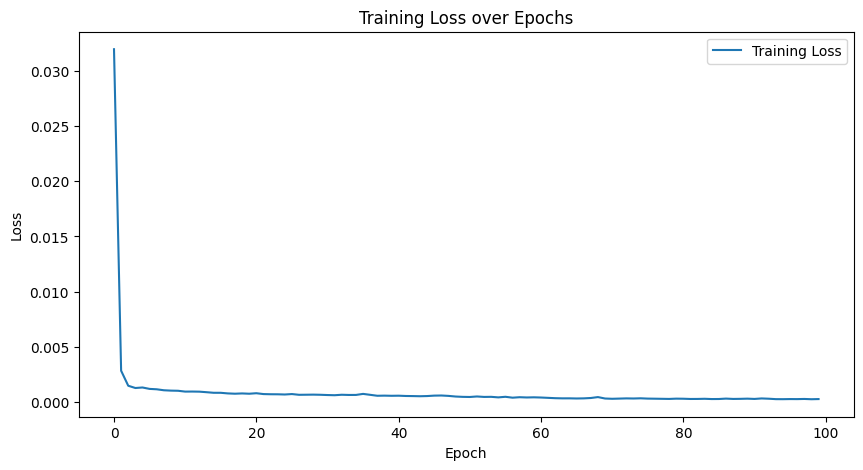

In [ ]:
# Early stopping callback to prevent overfitting
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stop])

# Plot the training loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate the Model and Visualize Predictions


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


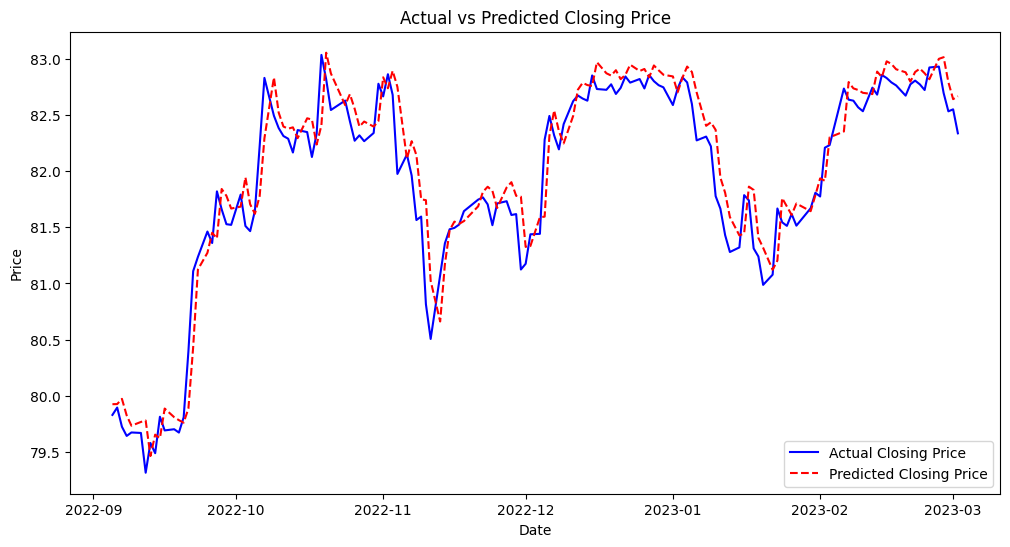


Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.20
Mean Squared Error (MSE): 0.07
Root Mean Squared Error (RMSE): 0.26


In [ ]:
# Make predictions on the test set
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test)

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(data.index[-test_size:], actual_prices, color='blue', label='Actual Closing Price')
plt.plot(data.index[-test_size:], predicted_prices, color='red', linestyle='dashed', label='Predicted Closing Price')
plt.title('Actual vs Predicted Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
# Step 3: Calculate and print evaluation metrics
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)

print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

define future prediction functions


In [ ]:
# Function to predict future prices
def predict_future(days_to_predict):
    last_sequence = closing_price_scaled[-sequence_length:]
    future_predictions = []

    for _ in range(days_to_predict):
        last_sequence_reshaped = last_sequence.reshape((1, sequence_length, 1))
        next_pred = model.predict(last_sequence_reshaped)
        future_price = scaler.inverse_transform(next_pred)[0][0]
        future_predictions.append(future_price)
        last_sequence = np.append(last_sequence[1:], next_pred, axis=0)

    return future_predictions


Get User Input and Predict Future Prices

Enter the number of days to predict into the future: 90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms

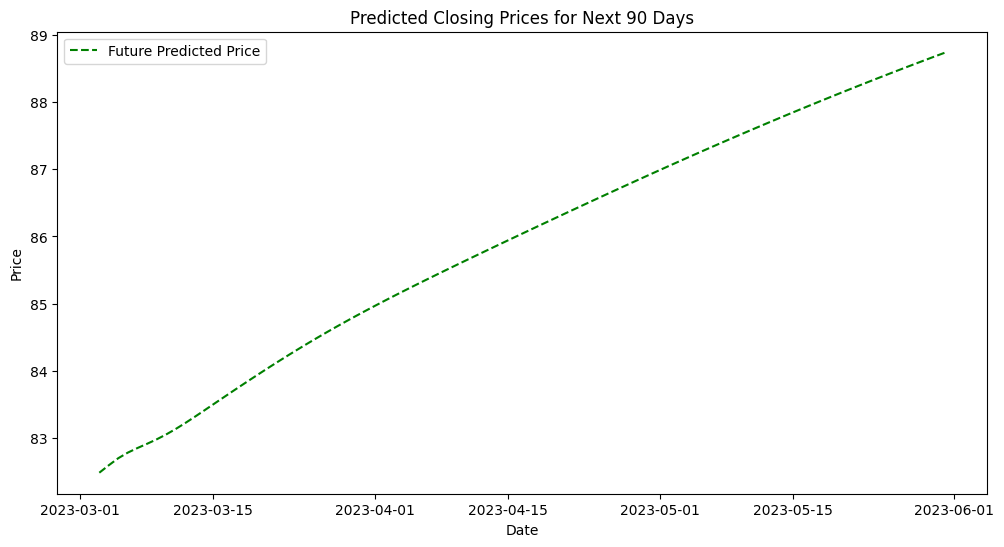

Future Price Predictions:
Predicted closing price on 2023-03-03: ₹82.48
Predicted closing price on 2023-03-04: ₹82.59
Predicted closing price on 2023-03-05: ₹82.70
Predicted closing price on 2023-03-06: ₹82.78
Predicted closing price on 2023-03-07: ₹82.85
Predicted closing price on 2023-03-08: ₹82.91
Predicted closing price on 2023-03-09: ₹82.97
Predicted closing price on 2023-03-10: ₹83.05
Predicted closing price on 2023-03-11: ₹83.13
Predicted closing price on 2023-03-12: ₹83.22
Predicted closing price on 2023-03-13: ₹83.31
Predicted closing price on 2023-03-14: ₹83.40
Predicted closing price on 2023-03-15: ₹83.50
Predicted closing price on 2023-03-16: ₹83.59
Predicted closing price on 2023-03-17: ₹83.69
Predicted closing price on 2023-03-18: ₹83.78
Predicted closing price on 2023-03-19: ₹83.88
Predicted closing price on 2023-03-20: ₹83.97
Predicted closing price on 2023-03-21: ₹84.06
Predicted closing price on 2023-03-22: ₹84.15
Predicted closing price on 2023-03-23: ₹84.24
Predicte

In [ ]:
# Prompt user for days to predict into the future
days_to_predict = int(input("Enter the number of days to predict into the future: "))
future_prices = predict_future(days_to_predict)

# Generate future dates
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=days_to_predict)

# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_prices, color='green', linestyle='dashed', label='Future Predicted Price')
plt.title(f'Predicted Closing Prices for Next {days_to_predict} Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Display future predictions
print("Future Price Predictions:")
for date, price in zip(future_dates, future_prices):
    print(f"Predicted closing price on {date.date()}: ₹{price:.2f}")
